In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import os
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional, Conv1D, MaxPooling1D
from itertools import product
from keras.optimizers import Adam
from keras.losses import Huber
from keras.optimizers import RMSprop

In [19]:
# settings
CURRENCY = "EUR"
CUTOFF_DATE = "2022-12-21"
PRED_END_DATE = "2025-02-01"
TIME_STEP = 10
EPOCHS = 100
BATCH_SIZE = 16
SAVE_DIR = f"../model/{CURRENCY}"
os.makedirs(SAVE_DIR, exist_ok=True)

In [20]:
# load data
df = pd.read_csv("../data/returns_2014_2025_filtered.csv", parse_dates=["Date"])
df = df.set_index("Date")
df = df[[CURRENCY]].copy()

In [42]:
# feature engineering
def compute_rsi(series, window=10):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["MA_5"] = df[CURRENCY].rolling(5).mean()
df["MA_10"] = df[CURRENCY].rolling(10).mean()
df["RSI"] = compute_rsi(df[CURRENCY]).rolling(3).mean()
df["Momentum_5"] = df[CURRENCY] - df[CURRENCY].shift(5)
df["Momentum_10"] = df[CURRENCY] - df[CURRENCY].shift(10)
df["Volatility_5"] = df[CURRENCY].rolling(5).std()
df["Volatility_10"] = df[CURRENCY].rolling(10).std()
df["target"] = df[CURRENCY].shift(-1).rolling(5).mean()
# Lagged target features
for lag in [1, 2, 3, 5, 7]:
    df[f"lag_target_{lag}"] = df["target"].shift(lag)
    
# Mean diff and Z-score
mean_20 = df[CURRENCY].rolling(20).mean()
std_20 = df[CURRENCY].rolling(20).std()
df["MA_diff"] = df["MA_5"] - df["MA_10"]
df["Z_Score"] = (df[CURRENCY] - mean_20) / std_20

target_scaler = StandardScaler()
df["target_scaled"] = target_scaler.fit_transform(df["target"].values.reshape(-1, 1)).flatten()
df.dropna(inplace=True)

In [43]:
# ---------- TRAIN/TEST SPLIT ----------
features = [
    "MA_5", "MA_10", "RSI",
    "Momentum_5", "Momentum_10",
    "Volatility_5", "Volatility_10",
    "lag_target_1", "lag_target_2",
    "lag_target_3", "lag_target_5", "lag_target_7",
    "MA_diff", "Z_Score"
]

X_full = df[features].values
y_full = df["target_scaled"].values

scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

X_train_scaled = X_full_scaled[df.index < CUTOFF_DATE]
y_train = y_full[df.index < CUTOFF_DATE]

X_test_scaled = X_full_scaled[(df.index >= CUTOFF_DATE) & (df.index <= PRED_END_DATE)]
y_test = y_full[(df.index >= CUTOFF_DATE) & (df.index <= PRED_END_DATE)]

In [44]:
# ---------- CREATE SEQUENCES ----------
def create_dataset(data, target, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        # y.append(data[i + time_step, -1])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

In [45]:
# Create full sequences
X_seq, y_seq = create_dataset(X_full_scaled, y_full, TIME_STEP)

# Use index to split
X_train = X_seq[df.index[TIME_STEP:] < CUTOFF_DATE]
y_train = y_seq[df.index[TIME_STEP:] < CUTOFF_DATE]

X_test = X_seq[(df.index[TIME_STEP:] >= CUTOFF_DATE) & (df.index[TIME_STEP:] <= PRED_END_DATE)]
y_test = y_seq[(df.index[TIME_STEP:] >= CUTOFF_DATE) & (df.index[TIME_STEP:] <= PRED_END_DATE)]

In [ ]:
# ---------- MODEL ----------
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(TIME_STEP, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
history = model.fit(
    X_train_final, y_train_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ---------- EVALUATION ----------
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"{CURRENCY} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Epoch 1/100


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.7723 - val_loss: 0.6620
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5703 - val_loss: 0.6222
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5280 - val_loss: 0.6450
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5255 - val_loss: 0.6224
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5077 - val_loss: 0.6522
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4896 - val_loss: 0.5841
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4466 - val_loss: 0.6069
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4416 - val_loss: 0.6285
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4133 - val_loss: 0.6447
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4483 - val_loss: 0.6100
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4315 - val_loss: 0.6643
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
EUR — RMSE

In [ ]:
# ---------- MODEL ----------
# BEST parameter, feature set 1
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(TIME_STEP, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss=Huber(delta=1.0))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
history = model.fit(
    X_train_final, y_train_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ---------- EVALUATION ----------
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"{CURRENCY} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Epoch 1/100


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.3262 - val_loss: 0.2900
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2408 - val_loss: 0.2779
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2389 - val_loss: 0.2597
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2219 - val_loss: 0.2538
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2245 - val_loss: 0.2704
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2204 - val_loss: 0.2574
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2118 - val_loss: 0.2565
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2083 - val_loss: 0.2527
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2105 - val_loss: 0.2547
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1969 - val_loss: 0.2663
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1916 - val_loss: 0.2581
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

In [ ]:
# ---------- MODEL ----------
# BEST parameter, feature set 2
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(TIME_STEP, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss=Huber(delta=1.0))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
history = model.fit(
    X_train_final, y_train_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ---------- EVALUATION ----------
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"{CURRENCY} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Epoch 1/100


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3075 - val_loss: 0.2623
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2333 - val_loss: 0.2581
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2125 - val_loss: 0.2514
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2141 - val_loss: 0.2556
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2001 - val_loss: 0.2450
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1936 - val_loss: 0.2509
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1968 - val_loss: 0.2468
Epoch 8/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1814 - val_loss: 0.2525
Epoch 9/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1868 - val_loss: 0.2571
Epoch 10/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1866 - val_loss: 0.2598
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
EUR — RMSE: 0.0013, MAE: 0.0010, R2: 0.4482


In [ ]:
# Add convolutional layers to extract short-term patterns before LSTM:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(TIME_STEP, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss=Huber(delta=1.0))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
history = model.fit(
    X_train_final, y_train_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ---------- EVALUATION ----------
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"{CURRENCY} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Epoch 1/100


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3620 - val_loss: 0.2837
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2390 - val_loss: 0.2594
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2269 - val_loss: 0.2539
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2105 - val_loss: 0.2460
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2066 - val_loss: 0.2401
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1951 - val_loss: 0.2461
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1917 - val_loss: 0.2409
Epoch 8/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1929 - val_loss: 0.2342
Epoch 9/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1785 - val_loss: 0.2342
Epoch 10/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1736 - val_loss: 0.2362
Epoch 11/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1773 - val_loss: 0.2533
Epoch 12/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [51]:
# Try Keras Tuner
from keras_tuner import Hyperband
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
from keras.losses import Huber

def build_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Choice('filters', values=[32, 64]),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(TIME_STEP, X_train.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Bidirectional(LSTM(
        units=hp.Choice('lstm_units', [32, 64, 128]),
        return_sequences=True
    )))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    
    model.add(LSTM(hp.Choice('lstm2_units', [32, 64])))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss=Huber()
    )
    return model

from keras_tuner import Hyperband

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='keras_tuner_dir',
    project_name=f"{CURRENCY}_lstm_tuning"
)

early_stop = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    X_train_final, y_train_final,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

# Retrieve best model
best_model = tuner.get_best_models(num_models=1)[0]
# ---------- EVALUATION ----------
y_pred = best_model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"{CURRENCY} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Trial 30 Complete [00h 00m 10s]
val_loss: 0.23240308463573456

Best val_loss So Far: 0.22114768624305725
Total elapsed time: 00h 03m 45s


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
EUR — RMSE: 0.0012, MAE: 0.0010, R2: 0.4664


In [52]:
# save best model's parameters
import json
best_hp = tuner.get_best_hyperparameters(1)[0]

# Save to JSON
with open(f"{SAVE_DIR}/best_hyperparameters.json", "w") as f:
    json.dump(best_hp.values, f, indent=4)

# Optional: print in a clean way
print("✅ Best Model Hyperparameters:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

✅ Best Model Hyperparameters:
filters: 64
kernel_size: 5
lstm_units: 32
dropout_1: 0.2
lstm2_units: 32
dropout_2: 0.4
optimizer: adam
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


In [54]:
# Add convolutional layers to extract short-term patterns before LSTM:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(TIME_STEP, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss=Huber(delta=1.0))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
history = model.fit(
    X_train_final, y_train_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ---------- EVALUATION ----------
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"{CURRENCY} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3570 - val_loss: 0.2596
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2182 - val_loss: 0.2424
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2112 - val_loss: 0.2388
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2070 - val_loss: 0.2399
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1890 - val_loss: 0.2312
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1901 - val_loss: 0.2335
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1947 - val_loss: 0.2337
Epoch 8/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1796 - val_loss: 0.2290
Epoch 9/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1897 - val_loss: 0.2478
Epoch 10/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1840 - val_loss: 0.2272
Epoch 11/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1806 - val_loss: 0.2290
Epoch 12/100
162/162 ━━━━━━━━━━━━━━━━━━━━

In [58]:
# Add convolutional layers to extract short-term patterns before LSTM:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(TIME_STEP, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss=Huber(delta=1.0))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
history = model.fit(
    X_train_final, y_train_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ---------- EVALUATION ----------
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"{CURRENCY} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Epoch 1/100


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3710 - val_loss: 0.2663
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2279 - val_loss: 0.2538
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2215 - val_loss: 0.2505
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2081 - val_loss: 0.2398
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2020 - val_loss: 0.2439
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1921 - val_loss: 0.2327
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1963 - val_loss: 0.2438
Epoch 8/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1797 - val_loss: 0.2401
Epoch 9/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1796 - val_loss: 0.2276
Epoch 10/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1740 - val_loss: 0.2437
Epoch 11/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1774 - val_loss: 0.2344
Epoch 12/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [55]:
# ---------- SAVE MODEL ----------
model.save(f"{SAVE_DIR}/lstm_model.keras")
joblib.dump(scaler, f"{SAVE_DIR}/scaler.pkl")

# Exact number of predictions
n = len(y_test)

# Base index range (after sequencing)
test_dates = df[(df.index >= CUTOFF_DATE) & (df.index <= PRED_END_DATE)].index
date_index = test_dates[-n:]

# Build results DataFrame
results_df = pd.DataFrame({
    "Date": date_index,
    "Currency": [CURRENCY] * n,
    "Actual": y_test_inv.flatten(),
    "Predicted": y_pred_inv.flatten(),
    "RMSE": [rmse] * n,
    "MAE": [mae] * n,
    "R2": [r2] * n
})

# Save as CSV
results_df.to_csv(f"{SAVE_DIR}/lstm_predictions.csv", index=False)

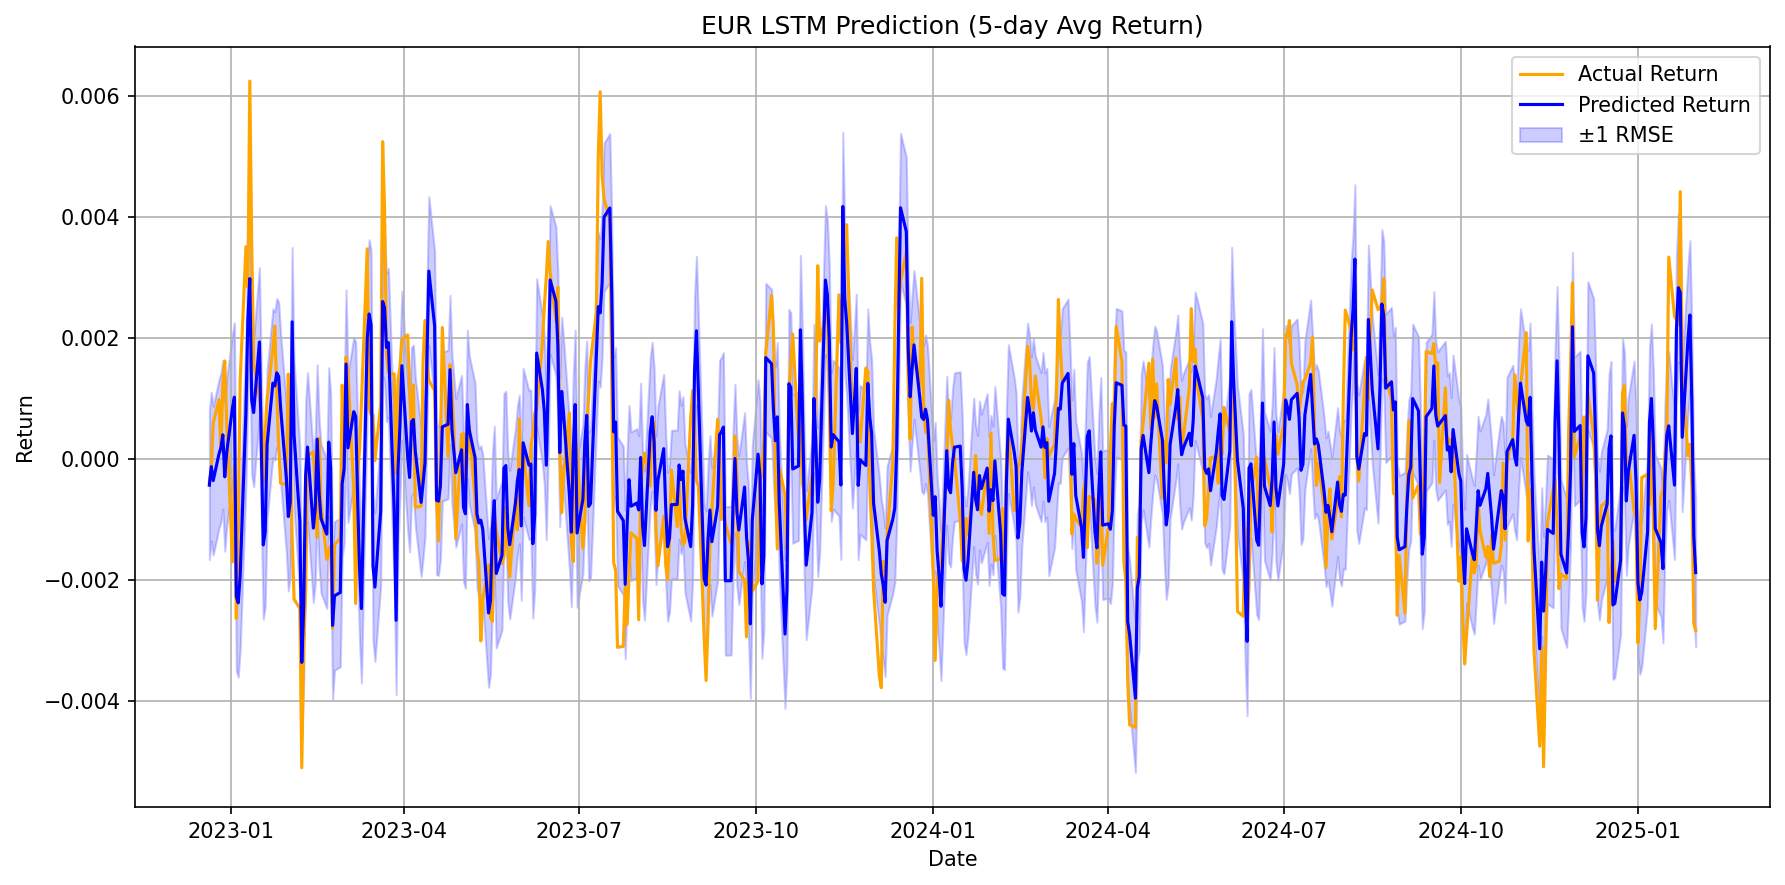

In [56]:
import matplotlib.pyplot as plt

# ----------- Plot: Predicted vs Actual with Confidence Interval ----------- #
plt.figure(figsize=(12, 6), dpi=150)

# Actual and predicted return lines
plt.plot(results_df["Date"], results_df["Actual"], label='Actual Return', color='orange')
plt.plot(results_df["Date"], results_df["Predicted"], label='Predicted Return', color='blue')

# Confidence band: ±1 RMSE
plt.fill_between(
    results_df["Date"],
    results_df["Predicted"] - rmse,
    results_df["Predicted"] + rmse,
    color='blue',
    alpha=0.2,
    label='±1 RMSE'
)

# Plot decorations
plt.title(f"{CURRENCY} LSTM Prediction (5-day Avg Return)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and show
plt.savefig(f"{SAVE_DIR}/prediction_interval.png")
plt.show()

## Make more improvements

In [17]:
# make the model better!
# Add grid search
search_space = {
    'lstm_units': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [16, 32],
    'time_step': [10, 20]
}

best_model = None
best_r2 = -np.inf
best_config = None

In [18]:
for lstm_units, dropout_rate, batch_size, time_step in product(
    search_space['lstm_units'],
    search_space['dropout_rate'],
    search_space['batch_size'],
    search_space['time_step']
):
    # Redefine sequences for new time_step
    X_seq, y_seq = create_dataset(X_full_scaled, y_full, time_step)
    X_train = X_seq[df.index[time_step:] < CUTOFF_DATE]
    y_train = y_seq[df.index[time_step:] < CUTOFF_DATE]
    X_test = X_seq[(df.index[time_step:] >= CUTOFF_DATE) & (df.index[time_step:] <= PRED_END_DATE)]
    y_test = y_seq[(df.index[time_step:] >= CUTOFF_DATE) & (df.index[time_step:] <= PRED_END_DATE)]

    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=(time_step, X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    history = model.fit(
        X_train_final, y_train_final,
        epochs=EPOCHS,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )

    y_pred = model.predict(X_test)
    y_pred_inv = target_scaler.inverse_transform(y_pred)
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    r2 = r2_score(y_test_inv, y_pred_inv)

    if r2 > best_r2:
        best_model = model
        best_r2 = r2
        best_config = {
            'lstm_units': lstm_units,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'time_step': time_step,
            'r2': r2
        }

# Print best config
print("Best Config:", best_config)


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/Users/zhouyihan/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Best Config: {'lstm_units': 64, 'dropout_rate': 0.2, 'batch_size': 16, 'time_step': 10, 'r2': 0.43253877150679354}


In [ ]:
# Best Config: {'lstm_units': 64, 'dropout_rate': 0.2, 'batch_size': 16, 'time_step': 10, 'r2': 0.43253877150679354}
# Add more layers

In [ ]:
best_model.save(f"{SAVE_DIR}/best_lstm_model.keras")
joblib.dump(scaler, f"{SAVE_DIR}/scaler.pkl")
joblib.dump(target_scaler, f"{SAVE_DIR}/target_scaler.pkl")